In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib notebook
sns.set()

In [2]:
import galsim
from des_psf import DESPSF

In [3]:
rng = np.random.RandomState(seed=10)

In [4]:
psf = DESPSF(rng, 60)

In [15]:
_psf = psf.getPSF(galsim.PositionD(1, -1))

In [16]:
mom = galsim.hsm.FindAdaptiveMom(_psf.drawImage(scale=0.263, nx=33, ny=33))
print(_psf.calculateFWHM(), mom.observed_shape.g1, mom.observed_shape.g1)

0.9615922322320288 -0.0067342846444018506 -0.0067342846444018506


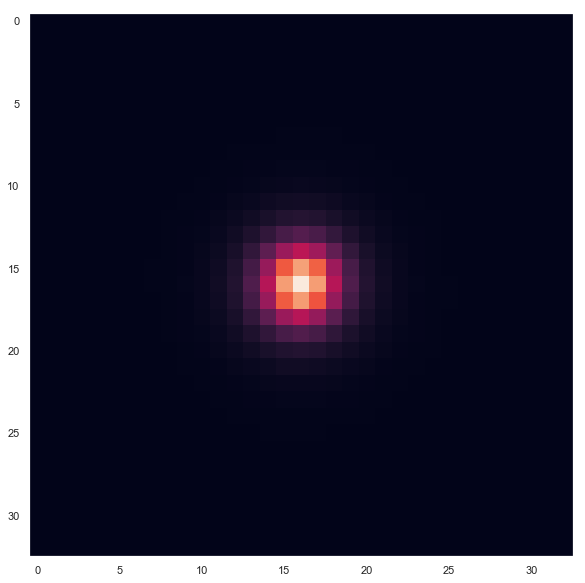

In [17]:
plt.figure(figsize=(10, 10))
ax = plt.gca()
ax.imshow(_psf.drawImage(nx=33, ny=33, scale=0.263).array)
ax.grid(False)

In [40]:
import tqdm

n = 10
fwhm = np.zeros((n, n))
g1 = np.zeros((n, n))
g2 = np.zeros((n, n))

for j, x in tqdm.tqdm(enumerate(np.linspace(-30, 30, n))):
    for i, y in enumerate(np.linspace(-30, 30, n)):
        pos = galsim.PositionD(x=x, y=y)
        _psf = psf.getPSF(pos)
        mom = galsim.hsm.FindAdaptiveMom(_psf.drawImage(scale=0.263, nx=33, ny=33))
        fwhm[i, j] = _psf.calculateFWHM()
        g1[i, j] = mom.observed_shape.g1
        g2[i, j] = mom.observed_shape.g2

10it [01:40, 10.11s/it]


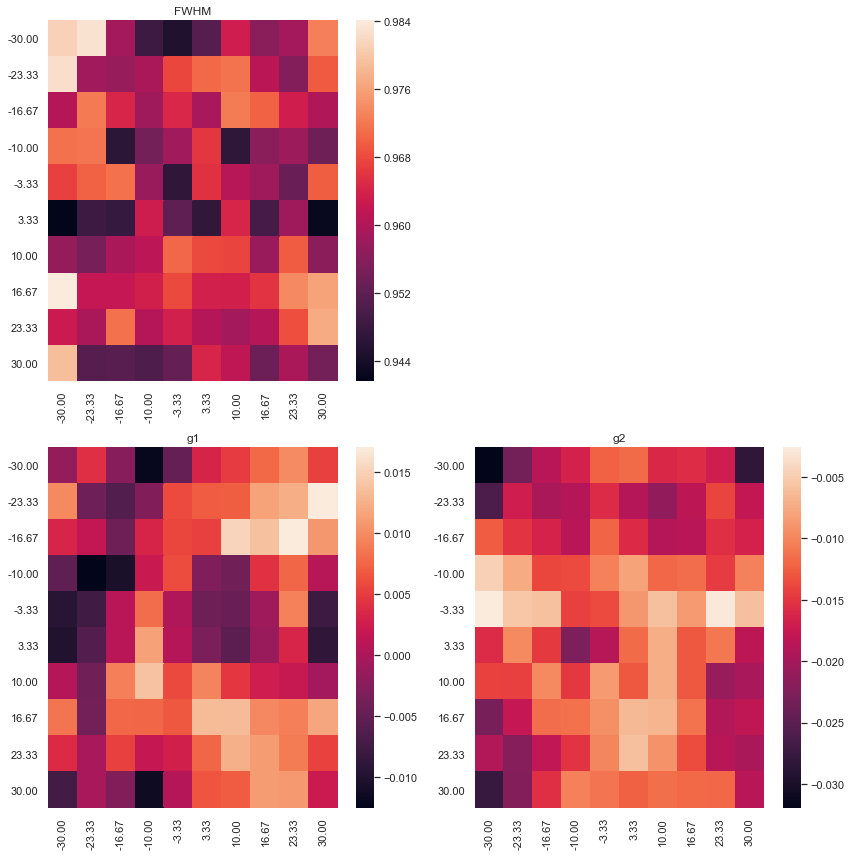

In [41]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

ax = axs[0, 0]
sns.heatmap(
    fwhm, 
    ax=ax, 
    xticklabels=["%0.2f" % _x for _x in np.linspace(-30, 30, n)],
    yticklabels=["%0.2f" % _x for _x in np.linspace(-30, 30, n)])
ax.set_title('FWHM')

ax = axs[0, 1]
ax.axis('off')

ax = axs[1, 0]
sns.heatmap(
    g1, 
    ax=ax, 
    xticklabels=["%0.2f" % _x for _x in np.linspace(-30, 30, n)],
    yticklabels=["%0.2f" % _x for _x in np.linspace(-30, 30, n)])
ax.set_title('g1')

ax = axs[1, 1]
sns.heatmap(
    g2, 
    ax=ax, 
    xticklabels=["%0.2f" % _x for _x in np.linspace(-30, 30, n)],
    yticklabels=["%0.2f" % _x for _x in np.linspace(-30, 30, n)])
ax.set_title('g2')

plt.tight_layout()

In [ ]:
im1 = psf.drawImage(scale=pixel_scale)
im2 = psf.shift(galsim.PositionD(x=10, y=10)).drawImage(scale=pixel_scale)
im3 = psf.drawImage(offset=galsim.PositionD(5, 5), scale=pixel_scale)

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

ax = axs[0]
ax.imshow(im1.array)
ax.grid(False)

ax = axs[1]
ax.imshow(im2.array)
ax.grid(False)

ax = axs[2]
ax.imshow(im3.array)
ax.grid(False)

In [ ]:
psf.calculateFWHM()

In [ ]:
from test_sim_utils import Sim, TEST_METADETECT_CONFIG

In [ ]:
from metadetect.metadetect_and_cal import MetadetectAndCal
from metadetect.metadetect import Metadetect

config = {}
config.update(TEST_METADETECT_CONFIG)

In [ ]:
rng = np.random.RandomState(seed=0)
sim = Sim(rng, config={'g1': 0.02})

In [ ]:
mbobs = sim.get_mbobs()
# md = Metadetect(config, mbobs, rng)
# md.go()

In [ ]:
plt.figure(figsize=(6, 6))
ax = plt.gca()
plt.imshow(np.arcsinh(mbobs[0][0].image))
ax.grid(False)
ax.set_xlabel('column')
ax.set_ylabel('row')
plt.savefig('example.pdf')

# plt.plot(md.result['noshear']['sx_col'], md.result['noshear']['sx_row'], 'ob')

# print(len(md.result['noshear']['sx_col']))

In [ ]:
import galsim

image = galsim.ImageD(33, 33, wcs=galsim.PixelScale(0.263))
im = sim._psf.draw(x=int(45.2+0.5), y=int(67.7+0.5), image=image)

In [ ]:
plt.figure(figsize=(10, 10))
ax = plt.gca()
ax.imshow(im.array)
ax.grid(False)

In [ ]:
def _meas_shear(res):
    op = res['1p']
    q = (op['flags'] == 0) & (op['wmom_s2n'] > 10) & (op['wmom_T_ratio'] > 1.2)
    g1p = op['wmom_g'][q, 0]
    
    om = res['1m']
    q = (om['flags'] == 0) & (om['wmom_s2n'] > 10) & (om['wmom_T_ratio'] > 1.2)
    g1m = om['wmom_g'][q, 0]
    
    o = res['noshear']
    q = (o['flags'] == 0) & (o['wmom_s2n'] > 10) & (o['wmom_T_ratio'] > 1.2)
    g1 = o['wmom_g'][q, 0]
    
    return g1p, g1m, g1

from scipy.optimize import curve_fit

def _get_stuff(rr):
    g1p = np.array([np.mean(r[0]) for r in rr])
    g1m = np.array([np.mean(r[1]) for r in rr])
    g1 = np.array([np.mean(r[2]) for r in rr])
    
    return g1, (g1p - g1m) / 2 / 0.01 * 0.02

def _fit_m(prr, mrr):
    g1p, R11p = _get_stuff(prr)
    g1m, R11m = _get_stuff(mrr)
    
    x = R11p + R11m
    y = g1p - g1m
    
    fres = curve_fit(lambda x, m: (1 + m) * x, x, y, [0])
    return fres[0][0], np.sqrt(fres[1][0, 0])

In [ ]:
import tqdm

offset = 12

with tqdm.trange(20) as itr:
    pres = []
    mres = []
    for i in itr:
        rng = np.random.RandomState(seed=i+offset)
        mbobs = Sim(rng, config={'g1': 0.02}).get_mbobs()
        md = Metadetect(config, mbobs, rng)
        md.go()
        pres.append(_meas_shear(md.result))

        rng = np.random.RandomState(seed=i+offset)
        mbobs = Sim(rng, config={'g1': -0.02}).get_mbobs()
        md = Metadetect(config, mbobs, rng)
        md.go()
        mres.append(_meas_shear(md.result))

In [ ]:
print("m: %f +/- %f" % _fit_m(pres, mres))